In [1]:
# Stable Diffusion 설치
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

In [2]:
# 메모리 삭제 (이미지를생성하다가 오류가 날때 사용하기)
# torch.cuda.empty_cache()


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so
/opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so...


/opt/conda/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//10.88.0.1'

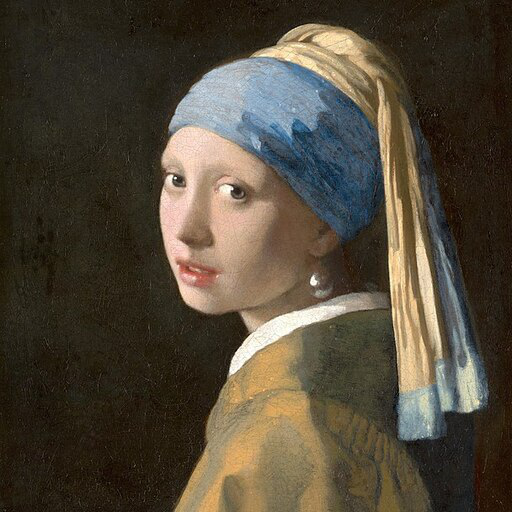

In [2]:
#윤곽선 검출
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image 

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

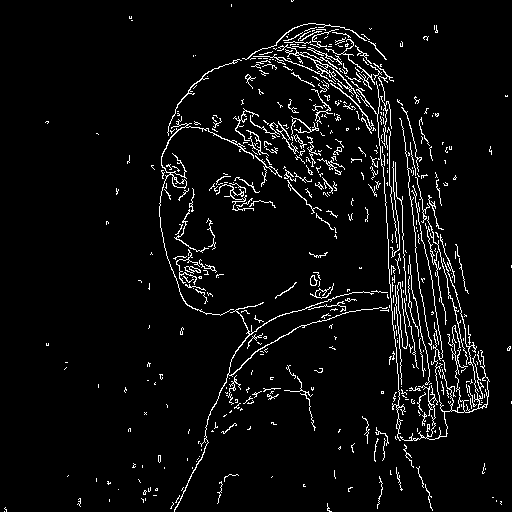

In [3]:
import cv2
from PIL import Image 
import numpy as np

# 이미지를 NumPy 배열로 변환합니다. 
image = np.array(image)

# threshold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다. 
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다. 

canny_image

In [4]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

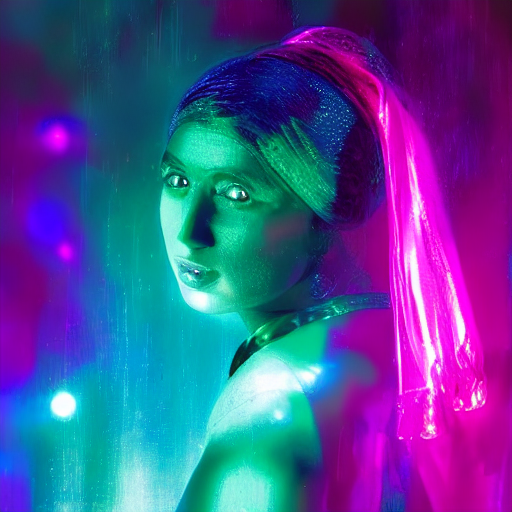

In [5]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights", 
    num_inference_steps=20, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/aiffel/canny_image.png")  

# 생성된 이미지를 출력합니다. 
canny_image

In [7]:
# 프롬프트와 하이퍼파라미터를 이용하여 이미지를 생성해 보세요.

prompt = "A surreal sunset over a futuristic cityscape reflecting on calm waters."
hyperparameters = {
    "temperature": 0.8,
    "max_tokens": 150,
    "top_p": 0.9
}

  0%|          | 0/20 [00:00<?, ?it/s]

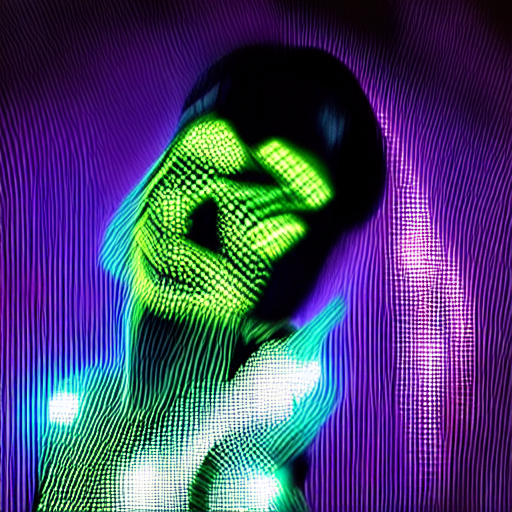

In [8]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights", 
    num_inference_steps=20, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/aiffel/canny_image.png")  

# 생성된 이미지를 출력합니다. 
canny_image

In [6]:
#인체자세감지
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

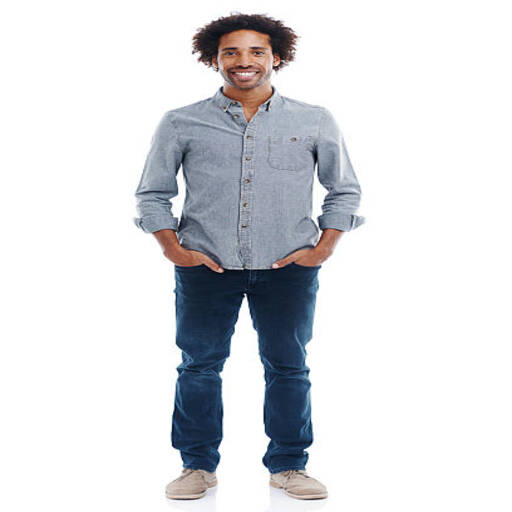

In [7]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

cuda


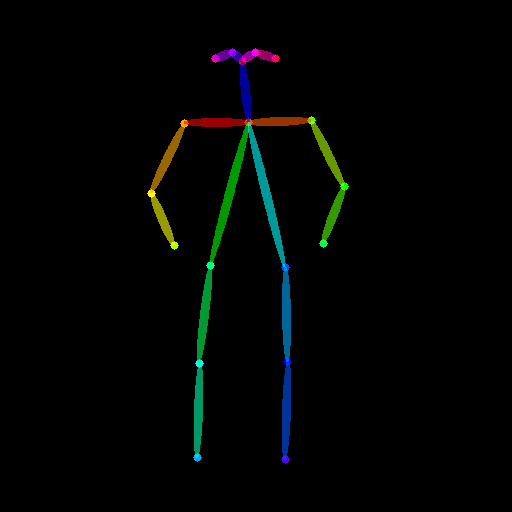

In [8]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [12]:
# 메모리 삭제 (이미지를생성하다가 오류가 날때 사용하기)
# torch.cuda.empty_cache()

In [9]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel 

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [14]:
# 메모리 삭제 (이미지를생성하다가 오류가 날때 사용하기)
torch.cuda.empty_cache()

  0%|          | 0/20 [00:00<?, ?it/s]

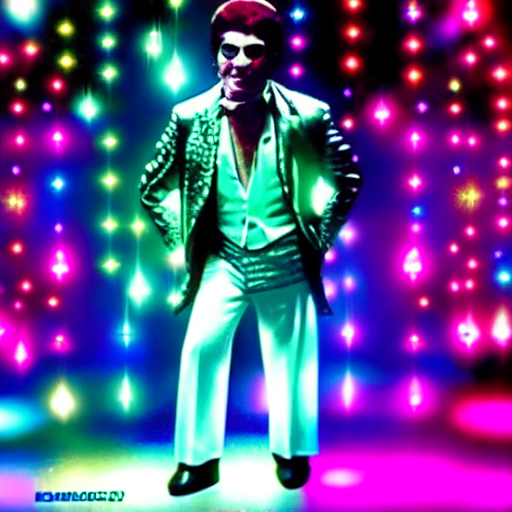

In [15]:

from diffusers import UniPCMultistepScheduler

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다. 
generator = torch.manual_seed(0)  

#프롬프트를 작성합니다. 
prompt = "A surreal sunset over a futuristic cityscape reflecting on calm waters."
negative_prompt = "A desolate wasteland with no signs of civilization."

images = openpose_image

# 이미지를 생성합니다. 
openpose_image1 =openpose_pipe(
    prompt="disco dancer with colorful lights", 
    num_inference_steps=20, 
    generator=generator, 
    image=openpose_image
).images[0]
# 생성된 이미지를 출력합니다. 
openpose_image1

쥬피터노트북에서는 돌아가지지않고.. 노드에서는 이미지가 생성되어서 노드에서출력된 이미지로 첨부합니다.

![](https://github.com/ImHyunSeok/lim/blob/master/hippo.png?raw=true)

In [10]:
#윤곽선검출 + 인체자세감지

from diffusers.utils import load_image 
from PIL import Image
import cv2
import numpy as np
from diffusers.utils import load_image

image = np.array(image)

# 이미지를 흑백으로 변환합니다.
canny_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Canny Edge Detection을 적용합니다.
low_threshold = 50
high_threshold = 150
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)

# 이미지를 NumPy 배열로 변환합니다. 
canny_image = np.array(canny_image)

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다. 
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다. 
canny_image = cv2.cvtColor(canny_image, cv2.COLOR_GRAY2RGB)
canny_image = Image.fromarray(canny_image)


cuda


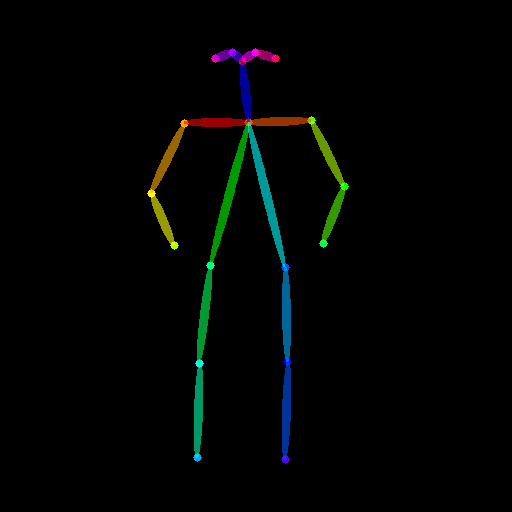

In [11]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image 
import os

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

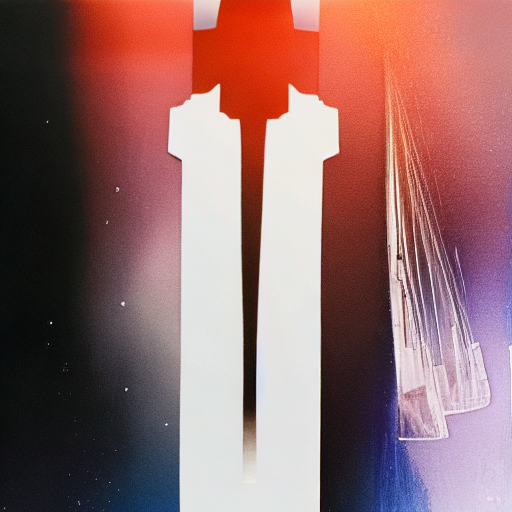

In [17]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from PIL import Image
import os

# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다.
controlnets = [ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16), ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)]

# 리스트 controlnets를 파이프라인으로 전달합니다.
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnets, torch_dtype=torch.float16
).to("cuda")

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다.
prompt = "A surreal sunset over a futuristic cityscape reflecting on calm waters."
negative_prompt = "A desolate wasteland with no signs of civilization."

# seed를 지정
generator = torch.Generator(device="cuda").manual_seed(0)

images = [openpose_image, canny_image]  # openpose_image와 canny_image는 이미지로 가정합니다.

# 이미지를 생성합니다.
canny_openpose_image = pipe(
    prompt,
    images,
    num_inference_steps=20,
    generator=generator,
    negative_prompt=negative_prompt).images[0]

# 이미지를 저장합니다.
file_path = os.path.join(os.getenv('HOME'), "aiffel/multi_controlnet_output.png")
canny_openpose_image.save(file_path)

# 이미지를 출력합니다.
canny_openpose_image.show()
